# A szövegekben megjelenő referáló kifejezések és referenciák áttekintése

Ez a dokumentum az egyes hanganyokban annotált referáló kifejezések és referenciák összesítésére készült. A dokumentumban a leíró statisztikai adatokat nyerem ki, melyek:
1. A szövegben előfordult összes referencia száma
2. A szöveg összes referáló kifejezésének számához való infók
3. A szöveg összes olyan IE-je és mondategysége, mely kódol referenciát
4. A referenciát kódoló IE-kben és mondatokban egyszerre kódolt referenciák átlaga és mediánja
5. Koreferencia vizualizáció (mondat- és IE alapú)
6. A hanganyag különleges módon kódolt (vx, tárgyas ragozás tárgya, passzív) referenciái
7. A hanganyag szakaszainak referenciái

In [1]:
import pprint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import csv
import seaborn as sns

data = pd.read_csv('N3_ref.csv', encoding='Latin-1', sep=';')

c:\users\noaidde\google drive\munka\disszertáció\elemzés\venv\lib\site-packages\scipy\__init__.py:137: UserWarning: NumPy 1.16.5 or above is required for this version of SciPy (detected version 1.16.2)
  UserWarning)


Áttekintés a hanganyag összes mondatáról.

In [3]:
print('A hanganyag összes mondatának száma: ', len(data['c_start'].unique()))

full_data = data[~data['clause_type'].isin(['part'])]
print('A hanganyag összes teljes mondatának száma: ', len(full_data['c_start'].unique()))

part_data = data[data['clause_type'] == 'part']
print('A hanganyag összes részleges mondatának száma: ', len(part_data['c_start'].unique()))

A hanganyag összes mondatának száma:  70
A hanganyag összes teljes mondatának száma:  62
A hanganyag összes részleges mondatának száma:  8


Gyors chack a hanganyag összes IE-jéről.

In [4]:
print('A hanganyag összes IE-jének száma: ', len(data['start'].unique()))

all_IE_data = data.set_index(['start', 'IE_type'])
print(all_IE_data.reset_index().groupby('IE_type')['start'].nunique())

A hanganyag összes IE-jének száma:  187
IE_type
fr            17
reg(cog)       2
reg(hes)      19
reg(int)       1
reg(text)     23
reg(val)       2
sub          123
Name: start, dtype: int64


A csv megnyitása után először **le kell szűrni azokat az IE-ket, amelyekkel foglalkozom**: a sub és fr típusúakat.

In [5]:
r_data = data[data['IE_type'].str.contains('sub') | data['IE_type'].str.contains('fr')]

Ezt követően **dobtam azokat a sorokat (IE-ket), amelyekben nem volt referáló kifejezés** és megnézem, hogy a referáló IE-k közül hány sub és hány fr típusú.

In [6]:
r_data = r_data.dropna(axis=0, subset=['referent_name'], inplace=False)
print('referáló IE-k: ', r_data.reset_index().groupby('IE_type')['start'].nunique())

referáló IE-k:  IE_type
sub    117
Name: start, dtype: int64


Ezek után következhet a tényleges elemzés.

## 1. A szövegben előfordult összes referencia száma
Először összesíteni kell a 'refent_name' oszlop önálló lexikai egységét, ez az összes annotált elem.

In [7]:
print('összes önálló jelölet (db, +gen, uncl): ', len(r_data['referent_name'].unique()))

count_row = r_data.shape[0] 
print('az összes sor száma (db, +gen, uncl): ', count_row)

def label_meaning (row):
    if 'gen(' in str(row['referent_name']):
        return 'gen'
    if row['referent_name'] == 'uncl()':
        return 'uncl()'
    if row['referent_name'] == 'uncl(ta)':
        return 'uncl(ta)'
    if row['referent_name'] == 'uncl(px)':
        return 'uncl(px)'
    else:
        return 'referent'

r_data['meaning_type'] = data.apply(lambda row: label_meaning(row), axis=1)
print('az összes sub/fr IE-ben annotált különböző jelölet (db): ', 
      r_data.reset_index().groupby('meaning_type')['referent_name'].nunique())

all_ref_data = r_data[r_data['meaning_type'] == 'referent']
print('az összes referáló sub és fr IE-k száma: ', all_ref_data.groupby('IE_type')['start'].nunique())

összes önálló jelölet (db, +gen, uncl):  47
az összes sor száma (db, +gen, uncl):  155
az összes sub/fr IE-ben annotált különböző jelölet (db):  meaning_type
gen         13
referent    32
uncl()       1
uncl(ta)     1
Name: referent_name, dtype: int64
az összes referáló sub és fr IE-k száma:  IE_type
sub    105
Name: start, dtype: int64


Viszont vannak olyan jelölések, amelyekkel **nem kell a továbbiakkal foglalkozni**: 
1. a szójelentésekkel (gen(q), gen(neg), gen(imp), gen(), gen - vagyis az összes gen elejű)
2. amiket nem tudtam címkézni, mert nem tudtam azonosítani a referenciát (uncl(), uncl(ta), uncl(px) - vagyis nem az összes uncl elejű)

Ezeket is ki kell dobni és megnézni ugyanígy, hogy hány önálló referenciával számolhatunk.

In [8]:
r_data = r_data[~r_data['referent_name'].str.contains('gen')]
r_data = r_data[~r_data['referent_name'].isin(['uncl()', 'uncl(ta)', 'uncl(px)'])]

print('összes önálló referencia (db): ', len(r_data['referent_name'].unique()))

count_row = r_data.shape[0] 
print('az összes sor száma (db): ', count_row)

print('az egyes referenciák előfordulása: ', r_data['referent_name'].value_counts().head(20))

összes önálló referencia (db):  32
az összes sor száma (db):  132
az egyes referenciák előfordulása:  N3                        31
N3_apja                    9
valami_fekete_izé          9
Tarak                      8
N3_és_testvérei            8
erdõ                       5
uncl(N3_és_családja)       5
ismertlen_valaki           4
N3_szülei                  4
uncl(N3_és_testvérei)      4
Kis-Sorohta                4
N3_anyja                   4
N3_apjának_meséi           4
N3_családja                3
Hurumpawel                 3
kutyák                     3
Kis-Sorohta_orosz_neve     2
takaró                     2
minden_este                2
egyik_este                 2
Name: referent_name, dtype: int64


## 2. A szöveg összes referáló kifejezésének száma

A **referáló kifejezések számának** megállapításához több tényezőt kell figyelembe venni:
1. **egy sor több referáló kifejezést is tartalmazhat** (ez pl. a 'POS' oszlopból szedhető ki: ahol vesszővel elválasztott kifejezések vannak, ott több ref.kifejezésről van szó - de elég azt megállapítani, hogy van-e vessző, mert max. 2db kifejezés volt megfigyelhető)
2. **egy referáló kifejezéshez több sor is tartozhat** (ez a 'RE_teljessege' oszlop és a 'whole_ref_ex' sorok kombinálásából kapható meg, itt a duplumokat/triplumokat el kell számolni, manuális munka, mert úgyis külön meg kell vizsgálni a különszakadó kifejezések szerkezetét.)
3. **ezekből számolva mennyi a fönti módon leszűkített df összes sora**

Ehhez jelenleg az összes annotált sor számát és a vesszőt tartalmazó sorok számát tudom kiszámolni. Ezen kívül azt is, hogy hány önálló referenciát fejezett ki (1 vagy több) törött kifejezés.

In [9]:
count_row = r_data.shape[0] 
print('az összes sor száma (db): ', count_row)

a = r_data['POS'].str.contains(',', regex=True).value_counts()
print('összes IE, ahol 1 ref-et több kifejezés ia kódol (a True-t kell nézni): ', a)

#tört kifejezések
fr_expression_data = r_data[r_data['RE_teljessege'] == 'fr']
print('összes sor, ahol fr lett jelölve:', fr_expression_data.shape[0])
print(fr_expression_data['referent_name'])

fr_ref_list = fr_expression_data['referent_name'].unique()
print('össz törött ref.kifejezéshez tartozó referencia: ', fr_ref_list)
print('törött ref.kifejezéshez tartozó referák darabszáma:', len(fr_ref_list))

az összes sor száma (db):  132
összes IE, ahol 1 ref-et több kifejezés ia kódol (a True-t kell nézni):  False    130
True       1
Name: POS, dtype: int64
összes sor, ahol fr lett jelölve: 13
12                    minden_este
20               N3_apjának_meséi
21               N3_apjának_meséi
53     N3_és_testvérei_kiskorában
55     N3_és_testvérei_kiskorában
83         Kis-Sorohta_orosz_neve
84         Kis-Sorohta_orosz_neve
93                          Tarak
94                          Tarak
198             valami_fekete_izé
199             valami_fekete_izé
223             ev(ez_a_történet)
224             ev(ez_a_történet)
Name: referent_name, dtype: object
össz törött ref.kifejezéshez tartozó referencia:  ['minden_este' 'N3_apjának_meséi' 'N3_és_testvérei_kiskorában'
 'Kis-Sorohta_orosz_neve' 'Tarak' 'valami_fekete_izé' 'ev(ez_a_történet)']
törött ref.kifejezéshez tartozó referák darabszáma: 7


## 3. A szöveg összes olyan IE-je és MONDATa, mely kódol referenciát

Összességében hány olyan IE-t és mondatot találni a szövegben, amely legalább 1 referenciát kódol?

In [10]:
print('A referenciát kódoló IE-k száma: ', len(r_data['start'].unique()))

print('A referenciát kódoló mondatok száma: ', len(r_data['c_start'].unique()))

f_cl_data = r_data[~r_data['clause_type'].isin(['part'])]
print('A referenciát kódoló teljes mondatok száma: ', len(f_cl_data['c_start'].unique()))

p_cl_data = r_data[r_data['clause_type'] == 'part']
print('A referenciát kódoló részleges mondatok száma: ', len(p_cl_data['c_start'].unique()))

A referenciát kódoló IE-k száma:  105
A referenciát kódoló mondatok száma:  62
A referenciát kódoló teljes mondatok száma:  56
A referenciát kódoló részleges mondatok száma:  6


## 4. A referenciát kódoló IE-kben és MONDATOKban egyszerre kódolt referenciák átlaga és mediánja

Ennek lépései:
1. A 'sentence' és az 'IE' oszlopot felhasználva felépítek egy többszintes indexelést,
2. kiiratom, hogy hány olyan IE/mondat van, amiben 1, 2 stb referencia szerpel.

Először az **IE-k** jönnek.

IE/ref medián:  1.0
IE/ref:  1    80
2    23
3     2
Name: referent_name, dtype: int64


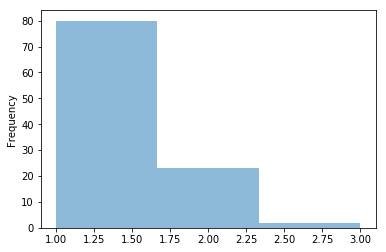

In [11]:
#IE-k/referenciák
ie_data = r_data.set_index(['speaker', 'start', 'referent_name'])

ie_data = ie_data.reset_index().groupby('start')['referent_name'].nunique()
#print(ie_data)

print('IE/ref medián: ', ie_data.median())
print('IE/ref: ', ie_data.value_counts())

ax = ie_data.plot.hist(bins=3, alpha=0.5)

Aztán lássuk a **mondatokat**: egyben, teljes és részleges mondatokra is lebontva.

összes mondat/ref medián:  1.0
összes mondat/ref:  1    34
2    21
3     4
4     2
5     1
Name: referent_name, dtype: int64
teljes mondat/ref medián:  1.0
teljes mondat/ref:  1    29
2    21
3     4
5     1
4     1
Name: referent_name, dtype: int64
részleges mondat/ref medián:  1.0
részleges mondat/ref:  1    5
4    1
Name: referent_name, dtype: int64


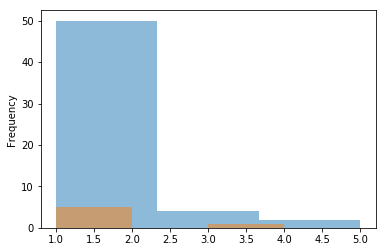

In [12]:
#összes mondat/referencia
cl_data = r_data.set_index(['speaker', 'c_start', 'clause_type', 'referent_name'])
all_cl_data = cl_data.reset_index().groupby('c_start')['referent_name'].nunique()

print('összes mondat/ref medián: ', all_cl_data.median())
print('összes mondat/ref: ', all_cl_data.value_counts())

#teljes mondat/referencia
full_cl_data = r_data[~r_data['clause_type'].isin(['part'])]
full_cl_data = full_cl_data.set_index(['speaker', 'c_start', 'referent_name'])
full_cl_data = full_cl_data.reset_index().groupby('c_start')['referent_name'].nunique()

print('teljes mondat/ref medián: ', full_cl_data.median())
print('teljes mondat/ref: ', full_cl_data.value_counts())
ax = full_cl_data.plot.hist(bins=3, alpha=0.5)

#részleges mondat/referencia
part_cl_data = r_data[r_data['clause_type'] == 'part']
part_cl_data = part_cl_data.set_index(['speaker', 'c_start', 'referent_name'])
part_cl_data = part_cl_data.reset_index().groupby('c_start')['referent_name'].nunique()

print('részleges mondat/ref medián: ', part_cl_data.median())
print('részleges mondat/ref: ', part_cl_data.value_counts())
ax = part_cl_data.plot.hist(bins=3, alpha=0.5)

## 5. Koreferencia vizualizáció
### 5.1 Mondatalapuló referenciaábrázolás

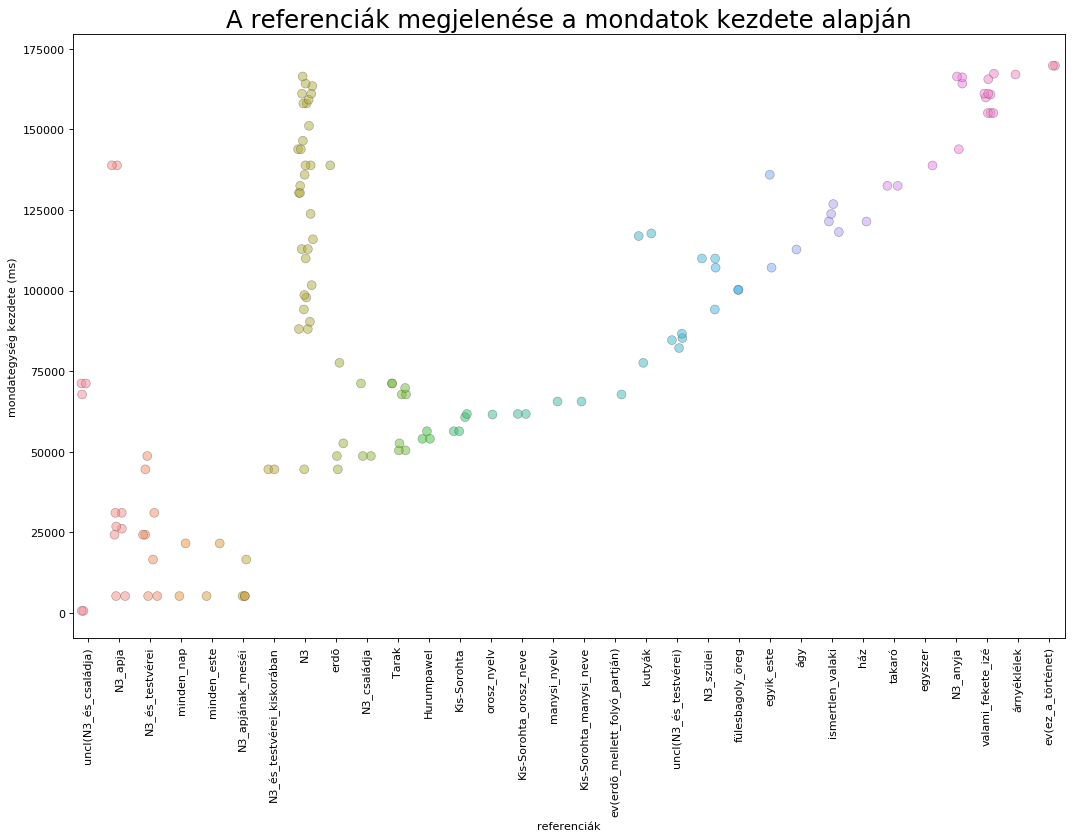

In [13]:
fig, ax = plt.subplots(figsize=(16,10), dpi= 80)
sns.stripplot(x=r_data['referent_name'], y=r_data['c_start'], alpha=.5, jitter=0.25, size=8, ax=ax, linewidth=.5)
ax.tick_params(axis='x', rotation=90)
plt.title('A referenciák megjelenése a mondatok kezdete alapján', fontsize=22)
plt.xlabel('referenciák')
plt.ylabel('mondategység kezdete (ms)')
plt.show()

### 5.2 IE-n alapuló referenciaábrázolás

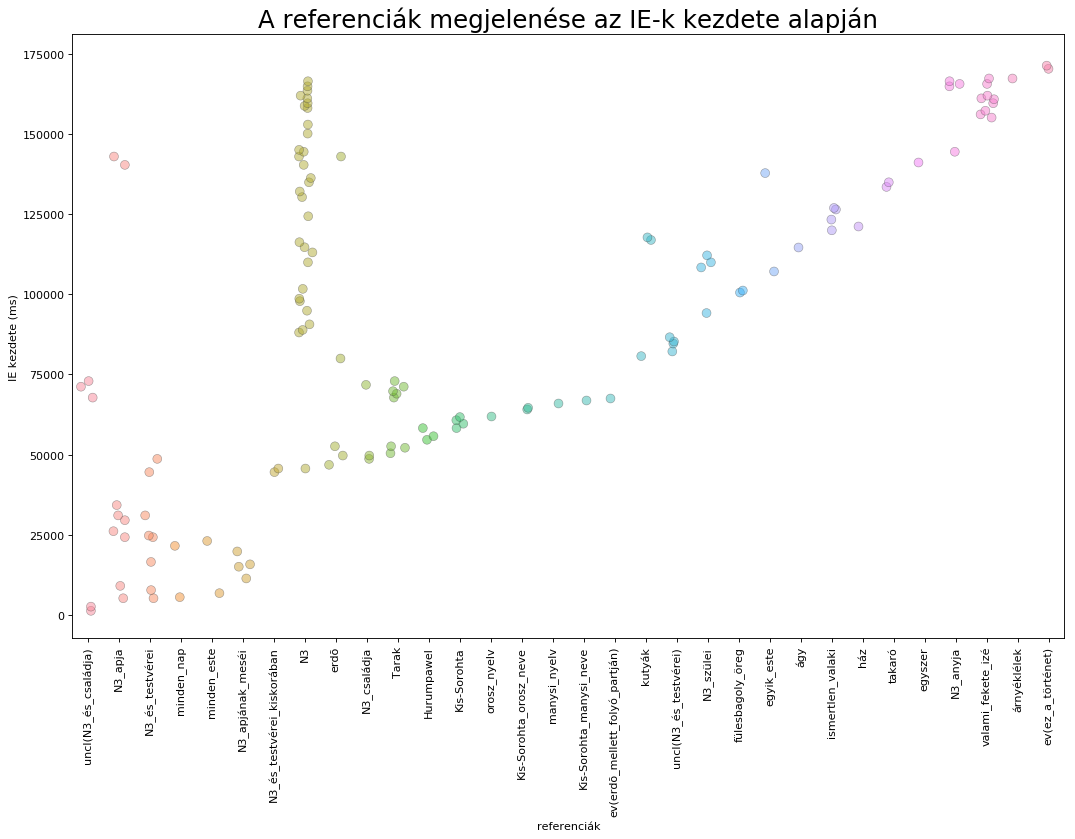

In [14]:
fig, ax = plt.subplots(figsize=(16,10), dpi= 80)
sns.stripplot(x=r_data['referent_name'], y=r_data['start'], alpha=.5, jitter=0.25, size=8, ax=ax, linewidth=.5)
ax.tick_params(axis='x', rotation=90)
plt.title('A referenciák megjelenése az IE-k kezdete alapján', fontsize=22)
plt.xlabel('referenciák')
plt.ylabel('IE kezdete (ms)')
plt.show()

## 6. A hanganyag különleges módon kódolt referenciái
### 6.1 Az igeraggal (is) kódolt referenciák

In [15]:
vx_data = r_data
vx_data['Vx'] = r_data['POS'].str.contains('vx', regex=True)
#print(vdata.head())
vx_data2 = vx_data[vx_data['Vx'] == True]
print('Vx-el (is) kifejezett referenciák: ', vx_data2['referent_name'].unique())

Vx-el (is) kifejezett referenciák:  ['uncl(N3_és_családja)' 'N3_apja' 'N3_apjának_meséi' 'N3_és_testvérei'
 'N3_családja' 'Tarak' 'Hurumpawel' 'Kis-Sorohta' 'kutyák'
 'uncl(N3_és_testvérei)' 'N3' 'fülesbagoly_öreg' 'N3_szülei'
 'ismertlen_valaki' 'takaró' 'valami_fekete_izé' 'N3_anyja']


### 6.2 A tárgyas ragozású igén tárgyként (is) kódolt referenciák

In [16]:
tdata = r_data[r_data['Vx_role'] == 'o']

index = tdata.index
number_of_rows = len(index)
print('összes tárgyas ragozás: ', number_of_rows)

a = tdata['referent_name'].unique()
print('referenciák: ', a)

összes tárgyas ragozás:  2
referenciák:  ['takaró' 'N3']


### 6.3 A passzív igeraggal (is) kódolt referenciák

In [17]:
tdata = r_data[r_data['cons'] == 'pass']

index = tdata.index
number_of_rows = len(index)
print('összes passzív ragozás: ', number_of_rows)

a = tdata['referent_name'].unique()
print('referenciák: ', a)

összes passzív ragozás:  0
referenciák:  []


## 7. A hanganyag hangsúlyos kifejezései

Érdekes, hogy: 
1. összesen **hány hangsúlyt jelöltem az anyagban** _(= a data df-el kell dolgozni, mert a többiből kizárom a nem sub/fr, referenciával nem annotált, gen/uncl sorokat)_,
2. **mekkora része volt referáló kifejezésbe, kvázi referáló kifejezésbe, illetve nem referáló kifejezésbe** eső _(= a data df-el kell dolgozni, mert a többiből kizárom a nem sub/fr, referenciával nem annotált, gen/uncl sorokat)_,
3. később érdekes lesz, hogy a TP és eTP alapján csoportosított referenciák mekkora része volt hangsúlyos, de ez csak a másik két scritben számolható. Ehhez a TP és eTP-s feldolgozóscripteken létre kell hozni egy olyan df-et, amelyen kategorizálom a hangsúlyjelöléseket.

In [18]:
stress_data = data
print('Az összes jelölt hangsúly', stress_data['stress'].value_counts())

stress_data2 = stress_data[stress_data['Vx_role'] == 'o']
print('A Vx-ek közül tárgyas ragozású (vagyis duplum): ', 
      stress_data2['stress'].value_counts())

Az összes jelölt hangsúly re(s)               19
v(s)                14
v(emp)              11
re(emp)              9
qre(emp)             4
nore(emp)            4
qre(s)               4
re(uc)               4
nore(s)              3
nore(uc)             3
v(uc)                2
re(emp), re(emp)     1
qre(uc)              1
qre(emp), qre(s)     1
re(s), re(uc)        1
Name: stress, dtype: int64
A Vx-ek közül tárgyas ragozású (vagyis duplum):  v(emp)    1
Name: stress, dtype: int64


## 8. A hanganyag szakaszainak referenciái

Az egyes témáknál hány melyek a többször előforduló refek?

In [19]:
section_data = r_data.set_index(['section', 'c_start', 'referent_name'])

theme_data = section_data.reset_index().groupby('section')['referent_name'].nunique()
print('Témánként megjelenő referenciák száma: ', theme_data)

theme_cl_data = section_data.reset_index().groupby('section')['c_start'].nunique()
print('Témánként megjelenő mondatok száma: ', theme_cl_data)

theme_f_cl_data = r_data[~r_data['clause_type'].isin(['part'])]
theme_f_cl_data = theme_f_cl_data.reset_index().groupby('section')['c_start'].nunique()
print('Témánként megjelenő teljes mondatok száma: ', theme_f_cl_data)

theme_p_cl_data = r_data[r_data['clause_type'] == 'part']
theme_p_cl_data = theme_p_cl_data.reset_index().groupby('section')['c_start'].nunique()
print('Témánként megjelenő részleges mondatok száma: ', theme_p_cl_data)

theme_ie_data = r_data.reset_index().groupby('section')['start'].nunique()
print('Témánként megjelenő referáló IE-k száma: ',theme_ie_data)

theme_ref_data = section_data.reset_index().groupby('section')['referent_name'].value_counts()
theme_ref_data.to_csv('N4_téma_per_ref_előfordulás', header=False)

Témánként megjelenő referenciák száma:  section
1_theme     6
2_theme    29
Name: referent_name, dtype: int64
Témánként megjelenő mondatok száma:  section
1_theme     8
2_theme    54
Name: c_start, dtype: int64
Témánként megjelenő teljes mondatok száma:  section
1_theme     8
2_theme    48
Name: c_start, dtype: int64
Témánként megjelenő részleges mondatok száma:  section
2_theme    6
Name: c_start, dtype: int64
Témánként megjelenő referáló IE-k száma:  section
1_theme    20
2_theme    85
Name: start, dtype: int64
